## Data Introduction

In [54]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import FuncFormatter
import statsmodels.stats.api as sms

In [2]:
jobs = pd.read_csv("../data/fullsample.csv")
 
jobs = jobs[jobs['END'] != 'Unknown']
jobs = jobs[jobs['STATE'] == 'COMPLETED']

jobs['REQTIME'] = pd.to_timedelta(jobs['REQTIME'])
jobs['USEDTIME'] = pd.to_timedelta(jobs['USEDTIME'])

jobs['BEGIN'] = pd.to_datetime(
    jobs['BEGIN'], 
    errors='coerce'
)
jobs['END'] = pd.to_datetime(
    jobs['END'], 
    errors='coerce'
)
jobs.head(5)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,-125 days +00:00:00,-126 days +23:59:37,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,-125 days +00:00:00,-126 days +23:59:46,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536Mn,20577.96M,-121 days +00:00:00,-122 days +23:59:56,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384Mn,9733.43M,-101 days +15:00:00,-101 days +14:59:43,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384Mn,9708.04M,-101 days +15:00:00,-84 days +07:27:33,1,1,production,0:0


In [3]:
jobs['END'].value_counts()

END
2021-07-12 11:36:02    312
2021-02-17 16:45:58    297
2021-02-17 16:45:57    284
2021-02-25 23:56:42    274
2021-06-16 22:34:57    247
                      ... 
2021-06-26 13:15:40      1
2021-06-26 14:25:14      1
2021-06-26 14:15:18      1
2021-06-26 13:16:56      1
2020-10-31 23:49:43      1
Name: count, Length: 4100858, dtype: int64

The fullsample dataset contains job records, with one row per job.

Each job gets a unique ID, contained in the **JOBID** column.

Some jobs can be submitted as arrays of similar jobs. These are listed with an underscore in the JOBID, where the number after the underscore indicates the tasknumber. For example. JOBID 31781951 was an array job with 10 parts. 

In [4]:
jobs[jobs['JOBID'].str.contains('31781951')]

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
533,31781951_1,COMPLETED,2021-08-30 12:51:30,2021-09-08 02:17:41,16384Mn,10234.37M,-50 days,-34 days +02:33:49,1,12,production,0:0
534,31781951_2,COMPLETED,2021-08-30 12:51:30,2021-09-07 18:04:48,16384Mn,10247.40M,-50 days,-34 days +10:46:42,1,12,production,0:0
535,31781951_3,COMPLETED,2021-08-31 09:14:29,2021-09-08 16:36:06,16384Mn,10064.47M,-50 days,-34 days +08:38:23,1,12,production,0:0
536,31781951_4,COMPLETED,2021-09-01 01:59:50,2021-09-08 08:48:28,16384Mn,10004.80M,-50 days,-30 days +13:11:22,1,12,production,0:0
537,31781951_5,COMPLETED,2021-09-02 00:09:27,2021-09-08 23:58:57,16384Mn,9858.72M,-50 days,-26 days +00:10:30,1,12,production,0:0
538,31781951_6,COMPLETED,2021-09-02 16:19:55,2021-09-10 11:16:57,16384Mn,10065.06M,-50 days,-30 days +01:02:58,1,12,production,0:0
539,31781951_7,COMPLETED,2021-09-02 22:26:08,2021-09-10 18:48:31,16384Mn,10092.55M,-50 days,-31 days +23:37:37,1,12,production,0:0
540,31781951_8,COMPLETED,2021-09-03 10:54:14,2021-09-11 09:32:28,16384Mn,10146.98M,-50 days,-31 days +21:21:46,1,12,production,0:0
541,31781951_9,COMPLETED,2021-09-04 22:54:03,2021-09-12 16:16:04,16384Mn,10050.81M,-50 days,-30 days +02:37:59,1,12,production,0:0
542,31781951_10,COMPLETED,2021-09-06 06:54:35,2021-09-14 13:02:37,16384Mn,10042.53M,-50 days,-34 days +09:51:58,1,12,production,0:0


Jobs can have a few differents states, with the most common one being 'COMPLETED'. 

In [5]:
jobs['STATE'].value_counts()

STATE
COMPLETED    7375084
Name: count, dtype: int64

The **BEGIN** field indicates when the job was started (initiated on a computer node).

The **END** field indicates when the job ended (completed, failed, or was cancelled while running).

The **REQMEM** field is the amount of memory requested in megabytes. It can be per-core/CPU (Mc) or per-node (Mn).



In [6]:
# Jobs where memory was requested per core.
jobs[jobs['REQMEM'].str[-2:] == 'Mc'].head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
501,31776583_1,COMPLETED,2021-08-30 10:16:59,2021-09-01 02:04:11,4096Mc,1792.43M,-59 days +16:00:00,-5 days +04:12:48,1,1,production,0:0
502,31776584_12,COMPLETED,2021-08-30 10:17:00,2021-09-01 00:20:15,4096Mc,1792.43M,-59 days +16:00:00,-5 days +05:56:45,1,1,production,0:0
915,31793401_958,COMPLETED,2021-08-31 19:36:46,2021-09-01 00:37:11,4096Mc,2788.05M,0 days 05:00:00,0 days 05:00:25,1,1,production,0:0
916,31793401_987,COMPLETED,2021-08-31 20:33:46,2021-09-01 00:02:57,4096Mc,2779.27M,0 days 05:00:00,0 days 03:29:11,1,1,production,0:0
4727,31813223_1296,COMPLETED,2021-08-31 19:42:46,2021-09-01 00:43:15,4096Mc,2786.44M,0 days 05:00:00,0 days 05:00:29,1,1,production,0:0


In [7]:
jobs['CPUS'].value_counts()

CPUS
1      5985134
4       484929
2       430787
8       170408
3        88783
12       62400
32       31288
16       27516
5        23863
10       14565
15       12825
6        12242
20       10293
13        7507
7         4473
24        4031
9         1396
11         934
128        352
18         338
25         231
40         162
36         160
64         106
48         102
26          63
50          42
14          35
100         30
30          23
60          20
80           8
35           7
23           6
28           6
72           5
22           4
96           3
19           2
17           2
52           1
51           1
125          1
Name: count, dtype: int64

In [8]:
# Jobs where memory was requested per node.
jobs[jobs['REQMEM'].str[-2:] == 'Mn'].head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,-125 days +00:00:00,-126 days +23:59:37,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,-125 days +00:00:00,-126 days +23:59:46,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536Mn,20577.96M,-121 days +00:00:00,-122 days +23:59:56,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384Mn,9733.43M,-101 days +15:00:00,-101 days +14:59:43,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384Mn,9708.04M,-101 days +15:00:00,-84 days +07:27:33,1,1,production,0:0


The USEDMEM column is the amount of memory used in MB per node.

The requested time (REQTIME) and used time (USEDTIME) columns are in d-hh:mm:ss or hh:mm:ss for jobs less than one day in duration.

**NODES** is the number of servers used for the job. Most jobs are single node. For multiple node jobs, memory usage is the maximum over all nodes.

**CPUS** is the total number of CPU cores allocated to the job, and for multi-node jobs, this includes all nodes.

Most jobs are run in the "production" or "nogpfs" partition. The "debug" and "sam" partitions are test jobs that are expected to be short, and the "maxwell", "pascal", and "turing" partitions are for GPU resources.

In [9]:
jobs['PARTITION'].value_counts()

PARTITION
production              7002182
nogpfs                   146659
pascal                   122963
sam                       64965
turing                    20638
maxwell                   10980
cgw-maizie                 4265
debug                      1434
cgw-platypus                371
cgw-dsi-gw                  227
cgw-capra1                  151
cgw-dougherty1              112
cgw-horus                    61
cgw-cqs1                     26
cgw-hanuman                  21
cgw-sideshowbob              13
cgw-vm-qa-flatearth1          9
cgw-tbi01                     7
Name: count, dtype: int64

The **EXITCODE** gives the [exit code](https://www.agileconnection.com/article/overview-linux-exit-codes) for the job, with "0:0" indicating a successful job. Exit codes have two numbers, where if the first number is non-zero, it indicates a problem on the server side and if the second is nonzero, it indicates a problem on the user side.

In [10]:
jobs['EXITCODE'].value_counts()

EXITCODE
0:0    7375084
Name: count, dtype: int64

In [11]:
jobs[jobs['EXITCODE'] == '1:0']

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE


In [12]:
jobs[jobs['EXITCODE'] == '0:15']

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE


In [13]:
def df_to_datelist(df1):
    
    df = df1.copy(deep = True)
    df[3] = df[3].str.replace('time ', '')
    df[3] = df[3].astype(float)


    df = df[df[1] == 'user 9204']
    df = df[df[3] >= 15]
    df = df[df[4] == "returncode 1"]
    
    df['sbatch'] = df[5].apply(lambda x: 1 if 'sbatch' in x else 0)
    df = df[df['sbatch'] == 1]
    df[0] = pd.to_datetime(df[0])
    
    
    return df[0].to_list()

The slurm_wrapper_ce5.log and slurm_wrapper_ce6.log files contain logs of jobs submitted from the Open Science Grid.

In [14]:
"""
chunksize = 10 ** 6
for chunk in pd.read_csv(filename, chunksize=chunksize):
# chunk is a DataFrame. To "process" the rows in the chunk:
for index, row in chunk.iterrows():
print(row)
"""


'\nchunksize = 10 ** 6\nfor chunk in pd.read_csv(filename, chunksize=chunksize):\n# chunk is a DataFrame. To "process" the rows in the chunk:\nfor index, row in chunk.iterrows():\nprint(row)\n'

In [15]:
%%time
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce5.head()

errors_ce6 = df_to_datelist(ce6)
errors_ce5 = df_to_datelist(ce5)
all_errors = errors_ce5 + errors_ce6


CPU times: total: 1min 5s
Wall time: 1min 44s


In [16]:
all_errors[0]

Timestamp('2020-10-18 06:53:44.272915')

For this project, we are interested in jobs from user 9204 (the test user) where the command starts with '/usr/bin/squeue', the returncode is non-zero and the time is greater than 15. These conditions indicate that the scheduler becaem unresponsive at that point in time.

In [17]:
jobs['END'].value_counts()



END
2021-07-12 11:36:02    312
2021-02-17 16:45:58    297
2021-02-17 16:45:57    284
2021-02-25 23:56:42    274
2021-06-16 22:34:57    247
                      ... 
2021-06-26 13:15:40      1
2021-06-26 14:25:14      1
2021-06-26 14:15:18      1
2021-06-26 13:16:56      1
2020-10-31 23:49:43      1
Name: count, Length: 4100858, dtype: int64

In [18]:
jobs.loc[1]['END'] - jobs.loc[1]['BEGIN']

Timedelta('30 days 00:00:23')

In [19]:
jobs.loc[1]['END'] - jobs.loc[1]['REQTIME']

Timestamp('2022-01-08 11:36:32')

In [20]:
jobs.loc[1]['END'] - all_errors[1]

Timedelta('322 days 04:42:27.677588')

In [21]:
len(all_errors)

3296

In [22]:
def count_jobs_before_interr(all_errors_func = all_errors, jobs_func = jobs, typeTime = 'h', countTime = 1, on = 'END'):
    """
    Calculates the number of jobs occurring within a specified time window 
    relative to each error timestamp, based on the relationship specified 
    (BEGIN, DURING, END, or ALL). Returns a DataFrame where each row corresponds 
    to an error and the number of jobs meeting the specified criteria.

    Parameters:
    ----------
    all_errors : pd.Series or iterable
        A list or Series of error timestamps. Each timestamp is used as 
        a reference point to count the jobs within the specified time window.

    jobs : pd.DataFrame
        A DataFrame containing job details with at least the following columns:
        - 'BEGIN': The start times of jobs.
        - 'END': The end times of jobs.

    typeTime : str, optional
        The unit of time for the countTime parameter. Accepted values are:
        - 'm': Minutes
        - 'h': Hours (default)
        - 'd': Days

    countTime : float, optional
        The size of the time window in the units specified by typeTime. 
        For example:
        - countTime=1 with typeTime='h' means a 1-hour window.
        - countTime=30 with typeTime='m' means a 30-minute window.

    on : str, optional
        Defines the relationship between the jobs and the error timestamp. 
        Accepted values are:
        - 'BEGIN': Count jobs whose start times fall within the time window 
                   before the error.
        - 'DURING': Count jobs that were active (spanning) during the error.
        - 'END': Count jobs whose end times fall within the time window 
                 before the error. (Default)
        - 'ALL': Generates a DataFrame with counts for all relationships:
            - 'Start Count': Number of jobs starting within the time window.
            - 'During Count': Number of jobs spanning the error timestamp.
            - 'End Count': Number of jobs ending within the time window.

    Returns:
    -------
    pd.DataFrame
        - For 'BEGIN', 'DURING', or 'END': A DataFrame where each row corresponds 
          to an error and its associated count of jobs based on the specified criteria.
        - For 'ALL': A DataFrame with columns 'Interruption Time', 'Start Count', 
          'During Count', and 'End Count'.

    Notes:
    -----
    - If an invalid value for `on` is provided, the function defaults to 'END' 
      and prints a warning message.
    - The 'ALL' option adds comprehensive job counts across all specified 
      relationships to the error timestamps.
    """
    
    
    
#     error_min_time = all_errors.min() - pd.Timedelta(hours=time_hours)
#         error_max_time = all_errors.max()

#          Filter jobs within the global range
#         jobs_filtered = jobs[(jobs['BEGIN'] <= error_max_time) & (jobs['END'] >= error_min_time)]
    
    time_dict = {
        'm': 60,
        'h': 1,
        'd': 1/24    
    }
    time_hours = countTime / time_dict[typeTime]
    error_min_time = min(all_errors) - pd.Timedelta(hours=time_hours)
    error_max_time = max(all_errors)
    on = on.strip().upper()
    errors_array = np.array(all_errors_func)
    all_errors_func = sorted(all_errors_func)
    
    if on == 'BEGIN':
        
        jobs_copy = jobs_func.copy(deep = True)
        jobs_copy = jobs_copy[(jobs_copy['BEGIN'] <= error_max_time) & (jobs_copy['BEGIN'] >= error_min_time)]
        jobs_copy = jobs_copy.sort_values('BEGIN')
        job_counts_for_interrupt = {}
        last_error_date = all_errors_func[0]
        for i, error in enumerate(tqdm(all_errors_func, desc="Processing Errors")):
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            if (error - last_error_date).days >= 30:
                jobs_copy = jobs_copy[jobs_copy['BEGIN'] >= hour_less_than_given]
                print(last_error_date)
                last_error_date = error
                
            
            count = ((jobs_copy['BEGIN'] > hour_less_than_given) & (jobs_copy['BEGIN'] <= error)).sum()
            job_counts_for_interrupt[error] = count
    
    elif on == 'DURING':
        
        jobs_copy = jobs_func.copy(deep = True)
        jobs_copy = jobs_copy[(jobs_copy['BEGIN'] <= error_max_time) & (jobs_copy['END'] >= error_min_time)]
        jobs_copy = jobs_copy.sort_values('END')
        job_counts_for_interrupt = {}
        last_error_date = all_errors_func[0]
        for i, error in enumerate(tqdm(all_errors_func, desc="Processing Errors")):
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            if (error - last_error_date).days >= 30:
                jobs_copy = jobs_copy[jobs_copy['END'] >= error]
                print(last_error_date)
                last_error_date = error
            #hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            count = ((jobs_copy['END'] > error) & (jobs_copy['BEGIN'] < error)).sum()
            job_counts_for_interrupt[error] = count
            
    elif on == 'END':
        
        jobs_copy = jobs_func.copy(deep = True)
        jobs_copy = jobs_copy[(jobs_copy['END'] <= error_max_time) & (jobs_copy['END'] >= error_min_time)]
        jobs_copy = jobs_copy.sort_values('END')
        job_counts_for_interrupt = {}
        last_error_date = all_errors_func[0]
        for i, error in enumerate(tqdm(all_errors_func, desc="Processing Errors")):
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            if (error - last_error_date).days >= 30:
                jobs_copy = jobs_copy[jobs_copy['END'] >= hour_less_than_given]
                print(last_error_date)
                last_error_date = error
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            count = ((jobs_copy['END'] > hour_less_than_given) & (jobs_copy['END'] <= error)).sum()
            job_counts_for_interrupt[error] = count
        
    elif on == 'ALL':
        
        jobs_copy = jobs_func.copy(deep = True)
        jobs_copy = jobs_copy[((jobs_copy['END'] <= error_max_time) & (jobs_copy['END'] >= error_min_time)) | ((jobs_copy['BEGIN'] <= error_max_time) & (jobs_copy['BEGIN'] >= error_min_time)) | ((jobs_copy['BEGIN'] <= error_max_time) & (jobs_copy['END'] >= error_min_time))]
        jobs_copy = jobs_copy.sort_values('END')
        
        job_counts_for_interrupt_begin = {}
        job_counts_for_interrupt_during = {}
        job_counts_for_interrupt_end = {}
        last_error_date = all_errors_func[0]

        for i, error in enumerate(tqdm(all_errors_func, desc="Processing Errors")):
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            if (error - last_error_date).days >= 30:
                jobs_copy = jobs_copy[jobs_copy['END'] >= hour_less_than_given]
                print(last_error_date)
                last_error_date = error

            countbegin = ((jobs_copy['BEGIN'] > hour_less_than_given) & (jobs_copy['BEGIN'] <= error)).sum()
            countduring = ((jobs_copy['END'] > error) & (jobs_copy['BEGIN'] < error)).sum()
            countend = ((jobs_copy['END'] > hour_less_than_given) & (jobs_copy['END'] <= error)).sum()
            
            job_counts_for_interrupt_begin[error] = countbegin
            job_counts_for_interrupt_during[error] = countduring
            job_counts_for_interrupt_end[error] = countend
            
        df1 =  pd.DataFrame(job_counts_for_interrupt_begin.items())
        #df.rename(columns={'A': 'a', 'B': 'c'}, inplace=True)
        df1.rename(columns = {1:'Start Count', 0:'Interruption Time'}, inplace = True)
        df1['During Count'] = job_counts_for_interrupt_during.values()
        df1['End Count'] = job_counts_for_interrupt_end.values()
        
        return df1
        
            
    else:
        
        
        
        print(f'Your "ON" variable of "{on}" was not found to be (BEGIN, END, DURING, or ALL), so defaulted to END.')
        
        jobs_copy = jobs_func.copy(deep = True)
        jobs_copy = jobs_copy[(jobs_copy['END'] <= error_max_time) & (jobs_copy['END'] >= error_min_time)]
        jobs_copy = jobs_copy.sort_values('END')
        job_counts_for_interrupt = {}
        last_error_date = all_errors_func[0]
        for i, error in enumerate(tqdm(all_errors_func, desc="Processing Errors")):
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            if (error - last_error_date).days >= 30:
                jobs_copy = jobs_copy[jobs_copy['END'] >= hour_less_than_given]
                print(last_error_date)
                last_error_date = error
            hour_less_than_given = error - pd.Timedelta(hours=time_hours)
            count = ((jobs_copy['END'] > hour_less_than_given) & (jobs_copy['END'] <= error)).sum()
            job_counts_for_interrupt[error] = count

        
    
    
    return pd.DataFrame(job_counts_for_interrupt.items())
   

In [23]:
# sort each list/dictionary by date (jobs by start or end depending) and then only go through specific dates each iteration.

In [24]:
dfall = count_jobs_before_interr(all_errors, jobs, 'h',1,'ALL')
dfall

Processing Errors:   3%|▎         | 90/3296 [00:25<15:29,  3.45it/s]

2020-10-18 06:16:25.392946


Processing Errors:  35%|███▍      | 1143/3296 [05:02<09:17,  3.86it/s]

2020-11-18 15:03:14.439449


Processing Errors:  49%|████▉     | 1613/3296 [06:54<06:35,  4.26it/s]

2020-12-18 15:18:59.450549


Processing Errors:  53%|█████▎    | 1733/3296 [07:23<05:46,  4.51it/s]

2021-01-17 16:28:49.469932


Processing Errors:  62%|██████▏   | 2059/3296 [08:30<04:19,  4.77it/s]

2021-02-16 16:58:11.049951


Processing Errors:  66%|██████▋   | 2190/3296 [08:56<07:29,  2.46it/s]

2021-03-19 08:29:39.070946


Processing Errors:  79%|███████▉  | 2607/3296 [10:02<04:35,  2.51it/s]

2021-04-18 14:59:17.312041


Processing Errors:  85%|████████▍ | 2788/3296 [10:29<02:51,  2.97it/s]

2021-05-20 08:10:47.902061


Processing Errors:  92%|█████████▏| 3043/3296 [11:00<01:02,  4.05it/s]

2021-06-19 11:57:52.170544


Processing Errors:  95%|█████████▌| 3133/3296 [11:09<00:23,  6.99it/s]

2021-07-19 12:36:10.601915


Processing Errors:  99%|█████████▉| 3255/3296 [11:15<00:00, 45.22it/s]

2021-08-20 12:03:28.102533


Processing Errors: 100%|██████████| 3296/3296 [11:16<00:00,  4.87it/s]


,Interruption Time,Start Count,During Count,End Count
0,2020-10-18 06:16:25.392946,180,3083,199
1,2020-10-18 06:38:44.172473,174,3063,205
2,2020-10-18 06:53:44.272915,202,3065,215
3,2020-10-18 06:54:04.322412,202,3065,214
4,2020-10-18 07:47:25.825172,274,3064,271
...,...,...,...,...
3291,2021-09-24 18:14:35.862916,764,1730,455
3292,2021-09-24 19:13:14.894282,552,1956,330
3293,2021-10-02 08:14:16.557499,619,3520,626
3294,2021-10-02 18:29:08.267199,299,3550,344


In [25]:
dfall[['Start Count','During Count','End Count']].describe()

,Start Count,During Count,End Count
count,3296.000000,3296.000000,3296.000000
mean,746.283070,3714.653519,714.854976
std,1120.339966,953.093815,1031.528272
min,0.000000,0.000000,0.000000
25%,165.000000,3212.000000,250.000000
50%,415.500000,3802.500000,451.000000
75%,910.000000,4365.000000,788.250000
max,15389.000000,6254.000000,15142.000000


In [26]:
# made new column to group the completions by 
jobs['end_day_hour'] = jobs['END'].dt.strftime('%Y-%m-%d %H')
# made new column to group the completions by 
error_list_hour = [x.strftime('%Y-%m-%d %H') for x in all_errors]
error_list_hour = set(error_list_hour)
error_list_hour

{'2021-04-18 15',
 '2021-07-02 16',
 '2021-01-30 17',
 '2021-06-30 20',
 '2021-04-30 11',
 '2020-11-11 18',
 '2021-03-04 09',
 '2021-01-27 23',
 '2020-12-03 05',
 '2021-07-14 09',
 '2021-01-04 11',
 '2021-01-16 15',
 '2021-08-24 22',
 '2021-05-04 07',
 '2021-06-15 21',
 '2021-05-02 17',
 '2020-12-05 23',
 '2021-09-13 10',
 '2021-09-09 13',
 '2021-09-23 23',
 '2021-02-05 12',
 '2021-05-13 22',
 '2020-12-04 14',
 '2021-05-01 22',
 '2020-12-04 19',
 '2021-03-18 06',
 '2020-11-01 12',
 '2021-01-17 01',
 '2021-04-02 18',
 '2020-12-11 19',
 '2021-05-14 15',
 '2021-02-06 18',
 '2021-04-30 04',
 '2021-05-18 06',
 '2021-01-06 10',
 '2021-03-29 22',
 '2020-12-14 12',
 '2021-02-01 12',
 '2021-09-07 15',
 '2020-12-09 10',
 '2020-10-19 00',
 '2021-01-11 15',
 '2021-03-07 00',
 '2021-03-01 10',
 '2021-02-01 11',
 '2020-12-19 23',
 '2021-01-17 14',
 '2021-04-27 15',
 '2021-06-03 22',
 '2021-01-11 16',
 '2020-12-20 18',
 '2021-05-08 20',
 '2021-04-23 10',
 '2021-03-21 21',
 '2020-12-12 02',
 '2021-07-

In [27]:
day_hour = jobs.groupby('end_day_hour').count()


date_hour = pd.DataFrame({
    'Count': jobs.groupby('end_day_hour').size()
}).reset_index()
date_hour.head()

date_hour['had_error'] = date_hour['end_day_hour'].isin(error_list_hour)

In [28]:
date_hour[date_hour['end_day_hour'] == '2021-05-03 09']

,end_day_hour,Count,had_error
5144,2021-05-03 09,1915,False


In [29]:
date_hour
date_hour['had_error'] = date_hour['had_error'].astype(int)
date_hour.describe()

,Count,had_error
count,8922.000000,8922.000000
mean,826.617799,0.150863
std,1187.221346,0.357935
min,2.000000,0.000000
25%,250.000000,0.000000
50%,487.000000,0.000000
75%,907.000000,0.000000
max,13346.000000,1.000000


In [30]:
count_interr_logfit = smf.logit("had_error ~ Count",
                          data = date_hour).fit()

Optimization terminated successfully.
         Current function value: 0.424045
         Iterations 6


In [31]:
count_interr_logfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              had_error   No. Observations:                 8922
Model:                          Logit   Df Residuals:                     8920
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:               0.0003733
Time:                        07:57:10   Log-Likelihood:                -3783.3
converged:                       True   LL-Null:                       -3784.7
Covariance Type:            nonrobust   LLR p-value:                   0.09278
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7616      0.036    -49.283      0.000      -1.832      -1.692
Count       3.983e-05   2.31e-05      1.721      0.085   -5.52e-06    8.52e-05
==============================================================================
"""

In [32]:
count_interr_logfit.params

Intercept   -1.761568
Count        0.000040
dtype: float64

In [33]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


count = 14000

logit_p = count_interr_logfit.params['Intercept'] + count_interr_logfit.params['Count']*count

print(f'Estimated Probability of Interruption: {logistic(logit_p)}')

#logistic(-5.52 * (10 ** -6))
#logistic(8.52 * (10 ** -5))

Estimated Probability of Interruption: 0.23077010535883208


(0.0, 1.0)

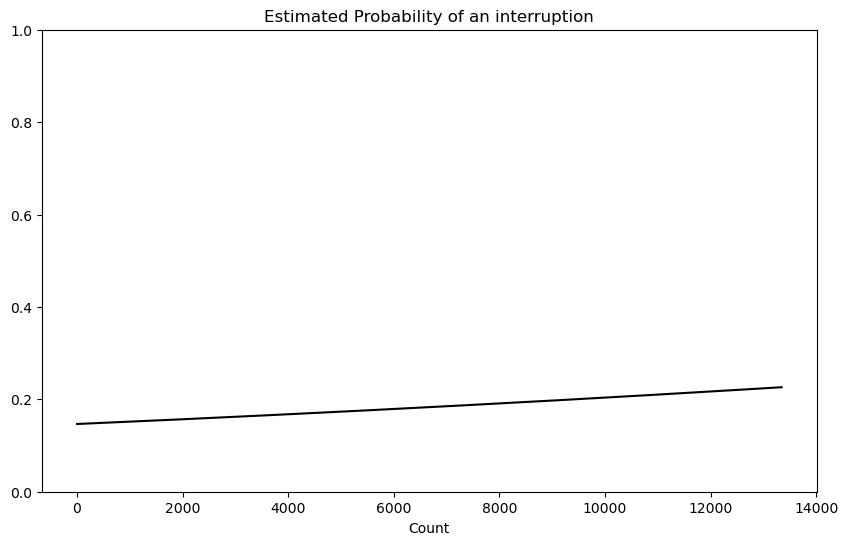

In [34]:
fit_df = pd.DataFrame({
    'Count': np.linspace(start = date_hour['Count'].min(),
                            stop = date_hour['Count'].max(),
                            num = 200)
})

fit_df['fit'] = count_interr_logfit.predict(fit_df)

fit_df.plot(x = 'Count',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of an interruption');

plt.ylim(0, 1)

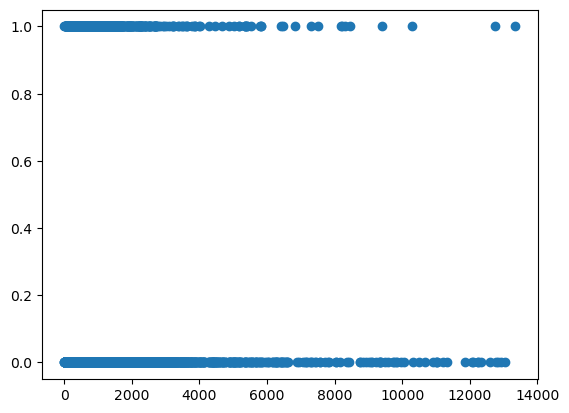

In [35]:
plt.scatter(date_hour['Count'], date_hour['had_error'])

In [36]:
all_errors

[Timestamp('2020-10-18 06:53:44.272915'),
 Timestamp('2020-10-18 06:54:04.322412'),
 Timestamp('2020-10-18 07:47:25.825172'),
 Timestamp('2020-10-18 07:47:45.871008'),
 Timestamp('2020-10-18 07:53:33.972840'),
 Timestamp('2020-10-18 16:02:01.338468'),
 Timestamp('2020-10-18 20:52:15.737852'),
 Timestamp('2020-10-19 00:23:37.945125'),
 Timestamp('2020-10-19 00:23:57.979047'),
 Timestamp('2020-10-19 01:01:02.211847'),
 Timestamp('2020-10-19 01:01:22.392363'),
 Timestamp('2020-10-19 01:23:30.029296'),
 Timestamp('2020-10-19 01:23:50.057180'),
 Timestamp('2020-10-19 02:49:45.479887'),
 Timestamp('2020-10-19 03:38:35.181625'),
 Timestamp('2020-10-19 03:59:19.595905'),
 Timestamp('2020-10-19 17:54:52.404285'),
 Timestamp('2020-10-19 21:46:47.528895'),
 Timestamp('2020-10-20 00:18:40.214164'),
 Timestamp('2020-10-22 21:19:15.358639'),
 Timestamp('2020-10-28 14:24:14.349391'),
 Timestamp('2020-10-29 09:39:11.896357'),
 Timestamp('2020-10-29 09:39:32.287111'),
 Timestamp('2020-11-01 12:04:57.38

In [40]:
def time_count_tf(errors = all_errors, jobdf = jobs, mins = 60):
    
    jobdf_copy = jobdf.copy(deep = True)
    timestring = f'{mins}T'
    errors_new_time = pd.DatetimeIndex(errors).floor(timestring)
    errors_new_time = errors_new_time.tolist()
    
#     jobdf_copy['end_day_min'] = jobdf_copy['END'].dt.floor(timestring).dt.strftime('%Y-%m-%d %H:%M:%S')
#     #newdf = jobdf_copy.groupby('end_day_min').count()
    
#     final_df = pd.DataFrame({
#         'Count': jobdf_copy.groupby('end_day_min').size()
#     }).reset_index()
    
#     final_df['had_error'] = final_df['end_day_min'].isin(errors_new_time)
#     final_df['had_error'] = final_df['had_error'].astype(int)
    
    return errors_new_time

time_count_tf(mins = 30)

[Timestamp('2020-10-18 06:30:00'),
 Timestamp('2020-10-18 06:30:00'),
 Timestamp('2020-10-18 07:30:00'),
 Timestamp('2020-10-18 07:30:00'),
 Timestamp('2020-10-18 07:30:00'),
 Timestamp('2020-10-18 16:00:00'),
 Timestamp('2020-10-18 20:30:00'),
 Timestamp('2020-10-19 00:00:00'),
 Timestamp('2020-10-19 00:00:00'),
 Timestamp('2020-10-19 01:00:00'),
 Timestamp('2020-10-19 01:00:00'),
 Timestamp('2020-10-19 01:00:00'),
 Timestamp('2020-10-19 01:00:00'),
 Timestamp('2020-10-19 02:30:00'),
 Timestamp('2020-10-19 03:30:00'),
 Timestamp('2020-10-19 03:30:00'),
 Timestamp('2020-10-19 17:30:00'),
 Timestamp('2020-10-19 21:30:00'),
 Timestamp('2020-10-20 00:00:00'),
 Timestamp('2020-10-22 21:00:00'),
 Timestamp('2020-10-28 14:00:00'),
 Timestamp('2020-10-29 09:30:00'),
 Timestamp('2020-10-29 09:30:00'),
 Timestamp('2020-11-01 12:00:00'),
 Timestamp('2020-11-02 13:30:00'),
 Timestamp('2020-11-09 12:00:00'),
 Timestamp('2020-11-09 12:30:00'),
 Timestamp('2020-11-09 13:00:00'),
 Timestamp('2020-11-

In [ ]:
functiondf = time_count_tf(mins = 60)
functiondf

In [ ]:
functiondf['end_day_min']

In [ ]:
functiondf[functiondf['end_day_min'] == '2020-10-16 10:00:00']

In [ ]:
jobs


In [41]:
def count_jobs_before_interr_mean(all_errors_func = all_errors, jobs_func = jobs, typeTime = 'h', countTime = 1, on = 'END'):
    
    time_dict = {
        'm': 60,
        'h': 1,
        'd': 1/24    
    }
    time_hours = countTime / time_dict[typeTime]
    error_min_time = min(all_errors_func) - pd.Timedelta(hours=time_hours)
    error_max_time = max(all_errors_func)
    
    jobs_copy = jobs_func.copy(deep = True)
    jobs_copy = jobs_copy[(jobs_copy['END'] <= error_max_time) & (jobs_copy['END'] >= error_min_time)]
    jobs_copy = jobs_copy.sort_values('END')
    job_counts_for_interrupt = {}
    last_error_date = all_errors_func[0]
    
    for error in tqdm(sorted(all_errors_func), desc="Processing Errors"):
        hour_less_than_given = error - pd.Timedelta(hours=time_hours)
        if (error - last_error_date).days >= 30:
            jobs_copy = jobs_copy[jobs_copy['END'] >= hour_less_than_given]
            last_error_date = error
            
        count = ((jobs_copy['END'] > hour_less_than_given) & (jobs_copy['END'] <= error)).sum()
        job_counts_for_interrupt[error] = count
    
    result_df = pd.DataFrame(job_counts_for_interrupt.items())
    mean_jobs = result_df[1].mean()
    
    print(f"\nAverage Number of Jobs Completed in {countTime}{typeTime} Before Error Ocurred: {mean_jobs:.2f}")
    
    return result_df

In [42]:
df1hour = count_jobs_before_interr_mean(typeTime = 'h', countTime = 1, on = 'END')
df45min = count_jobs_before_interr_mean(typeTime = 'm', countTime = 45, on = 'END')
df30min = count_jobs_before_interr_mean(typeTime = 'm', countTime = 30, on = 'END')
df15min = count_jobs_before_interr_mean(typeTime = 'm', countTime = 15, on = 'END')


Processing Errors: 100%|██████████| 3296/3296 [03:40<00:00, 14.93it/s] 



Average Number of Jobs Completed in 1h Before Error Ocurred: 714.85


Processing Errors: 100%|██████████| 3296/3296 [03:41<00:00, 14.88it/s] 



Average Number of Jobs Completed in 45m Before Error Ocurred: 531.25


Processing Errors: 100%|██████████| 3296/3296 [03:43<00:00, 14.72it/s] 



Average Number of Jobs Completed in 30m Before Error Ocurred: 353.85


Processing Errors: 100%|██████████| 3296/3296 [03:35<00:00, 15.28it/s] 


Average Number of Jobs Completed in 15m Before Error Ocurred: 171.68


In [ ]:
df1

In [ ]:
dfall['End Count'].mean()

In [43]:
def log_to_df(log):
    df = pd.read_csv(log,
        header=None,
        delimiter=' - ',
        engine='python')
    return df

def df_to_datelist(df1):
    df = df1.copy(deep = True)
    df[3] = df[3].str.replace('time ', '')
    df[3] = df[3].astype(float)
    df = df[df[1] == 'user 9204']
    df = df[df[3] >= 15]
    df = df[df[4] == "returncode 1"]
    df['sbatch'] = df[5].apply(lambda x: 1 if 'sbatch' in x else 0)
    df = df[df['sbatch'] == 1]
    df[0] = pd.to_datetime(df[0])
    return df[0].to_list()

In [44]:
jobs_15min = jobs.set_index('END').groupby(pd.Grouper(freq='15min')).size().reset_index(name = 'JobEndCount')
jobs_30min = jobs.set_index('END').groupby(pd.Grouper(freq='30min')).size().reset_index(name = 'JobEndCount')
jobs_45min = jobs.set_index('END').groupby(pd.Grouper(freq='45min')).size().reset_index(name = 'JobEndCount')
jobs_60min = jobs.set_index('END').groupby(pd.Grouper(freq='60min')).size().reset_index(name = 'JobEndCount')

jobs_15min = jobs_15min.rename(columns={'END': 'end_group'})
jobs_30min = jobs_30min.rename(columns={'END': 'end_group'})
jobs_45min = jobs_45min.rename(columns={'END': 'end_group'})
jobs_60min = jobs_60min.rename(columns={'END': 'end_group'})

error_df = pd.DataFrame({'error_timestamp': all_errors})

errors_15min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='15min')).size().reset_index(name = 'ErrorCount')
errors_30min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='30min')).size().reset_index(name = 'ErrorCount')
errors_45min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='45min')).size().reset_index(name = 'ErrorCount')
errors_60min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='60min')).size().reset_index(name = 'ErrorCount')

errors_15min = errors_15min.rename(columns={'END': 'end_group'})
errors_30min = errors_30min.rename(columns={'END': 'end_group'})
errors_45min = errors_45min.rename(columns={'END': 'end_group'})
errors_60min = errors_60min.rename(columns={'END': 'end_group'})

job_errors_60min = (
    pd.merge(
        left = jobs_60min,    
        right = errors_60min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

job_errors_45min = (
    pd.merge(
        left = jobs_45min,    
        right = errors_45min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

job_errors_30min = (
    pd.merge(
        left = jobs_30min,    
        right = errors_30min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

job_errors_15min = (
    pd.merge(
        left = jobs_15min,    
        right = errors_15min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

mean15min = job_errors_15min['JobEndCount'].mean()
mean30min = job_errors_30min['JobEndCount'].mean()
mean45min = job_errors_45min['JobEndCount'].mean()
mean60min = job_errors_60min['JobEndCount'].mean()

job_errors_15min['ErrorCheck'] = job_errors_15min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)
job_errors_30min['ErrorCheck'] = job_errors_30min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)
job_errors_45min['ErrorCheck'] = job_errors_45min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)
job_errors_60min['ErrorCheck'] = job_errors_60min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)

In [103]:
job_errors_15min

,end_group,JobEndCount,ErrorCount,ErrorCheck
0,2020-10-01 00:00:00,3,0.0,0
1,2020-10-01 00:15:00,30,0.0,0
2,2020-10-01 00:30:00,133,0.0,0
3,2020-10-01 00:45:00,255,0.0,0
4,2020-10-01 01:00:00,263,0.0,0
...,...,...,...,...
35694,2021-10-07 19:30:00,2,0.0,0
35695,2021-10-07 19:45:00,2,0.0,0
35696,2021-10-07 20:00:00,2,0.0,0
35697,2021-10-07 20:15:00,2,0.0,0


Optimization terminated successfully.
         Current function value: 0.221614
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             ErrorCheck   No. Observations:                35699
Model:                          Logit   Df Residuals:                    35697
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:               3.027e-05
Time:                        11:25:06   Log-Likelihood:                -7911.4
converged:                       True   LL-Null:                       -7911.6
Covariance Type:            nonrobust   LLR p-value:                    0.4889
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.7768      0.026   -104.850      0.000      -2.829      -2.725
JobEndCount -4.663e-05   6.81e-05     -0.684      0.494      -0.000    8.69e-05
===============================================================================
"""

<Figure size 400x1700 with 0 Axes>

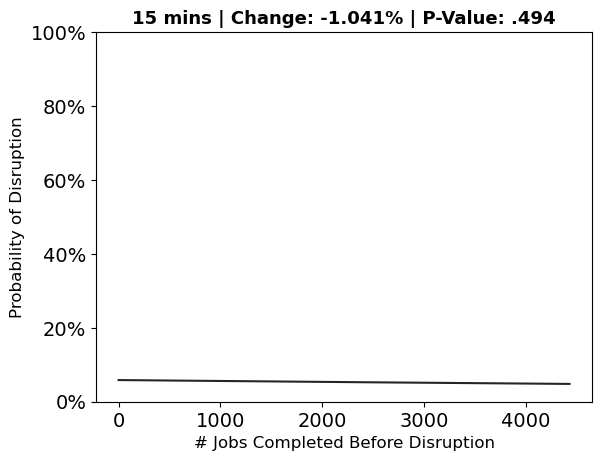

In [137]:
job_15min_log = smf.logit("ErrorCheck ~ JobEndCount",
                         data = job_errors_15min).fit()

fit_df = pd.DataFrame({
        'JobEndCount': np.linspace(start = job_errors_15min['JobEndCount'].min(),
                                stop = job_errors_15min['JobEndCount'].max(),
                                num = 200)
        })

fit_df['fit'] = job_15min_log.predict(fit_df)

fontSize = 14
plt.figure(figsize=(4, 17))

ax = fit_df.plot(
    x="JobEndCount", 
    y="fit", 
    kind="line", 
    color='Black', 
    alpha = .855,
    legend=False
)

def to_percent(y, _):
    return f"{y * 100:.0f}%"  

ax.yaxis.set_major_formatter(FuncFormatter(to_percent))


plt.xticks(rotation=0, fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.ylim(0, 1)
plt.xlabel('# Jobs Completed Before Disruption', fontsize = 12)
plt.ylabel('Probability of Disruption', fontsize = 12)
plt.title(f'15 mins | Change: {(fit_df["fit"].min() - fit_df["fit"].max()) * 100:.3f}% | P-Value: .494', fontsize = 13, fontweight = 'bold');
#plt.text(0.5, 1.03, f'Prediction P-Value: {0.04 }', fontsize=11, ha='center', transform=ax.transAxes)
plt.savefig('../assets/log15min.png', dpi = 150);
job_15min_log.summary()

Optimization terminated successfully.
         Current function value: 0.321990
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             ErrorCheck   No. Observations:                17850
Model:                          Logit   Df Residuals:                    17848
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:               1.382e-05
Time:                        11:25:20   Log-Likelihood:                -5747.5
converged:                       True   LL-Null:                       -5747.6
Covariance Type:            nonrobust   LLR p-value:                    0.6902
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.2193      0.030    -74.449      0.000      -2.278      -2.161
JobEndCount  1.541e-05   3.84e-05      0.401      0.688   -5.99e-05    9.07e-05
===============================================================================
"""

<Figure size 400x1700 with 0 Axes>

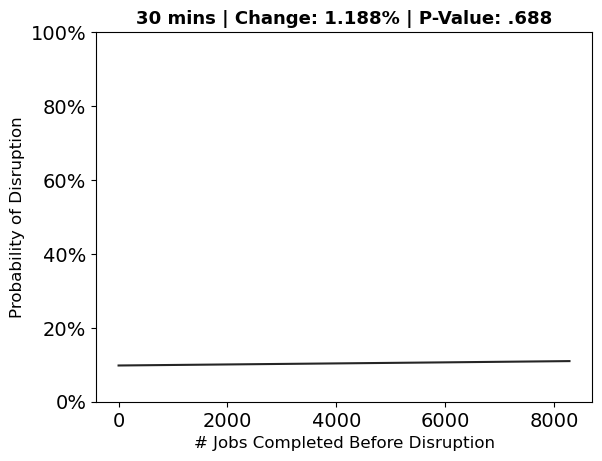

In [138]:
job_30min_log = smf.logit("ErrorCheck ~ JobEndCount",
                         data = job_errors_30min).fit()

fit_df = pd.DataFrame({
        'JobEndCount': np.linspace(start = job_errors_30min['JobEndCount'].min(),
                                stop = job_errors_30min['JobEndCount'].max(),
                                num = 200)
        })

fit_df['fit'] = job_30min_log.predict(fit_df)

fontSize = 14
plt.figure(figsize=(4, 17))

ax = fit_df.plot(
    x="JobEndCount", 
    y="fit", 
    kind="line", 
    color='Black', 
    alpha = .855,
    legend=False
)

def to_percent(y, _):
    return f"{y * 100:.0f}%"  

ax.yaxis.set_major_formatter(FuncFormatter(to_percent))


plt.xticks(rotation=0, fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.ylim(0, 1)
plt.xlabel('# Jobs Completed Before Disruption', fontsize = 12)
plt.ylabel('Probability of Disruption', fontsize = 12)
plt.title(f'30 mins | Change: {(fit_df["fit"].max() - fit_df["fit"].min()) * 100:.3f}% | P-Value: .688', fontsize = 13, fontweight = 'bold');
#plt.text(0.5, 1.03, f'Prediction P-Value: {0.04 }', fontsize=11, ha='center', transform=ax.transAxes)
plt.savefig('../assets/log30min.png', dpi = 150);

job_30min_log.summary()


Optimization terminated successfully.
         Current function value: 0.382630
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             ErrorCheck   No. Observations:                11900
Model:                          Logit   Df Residuals:                    11898
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:               0.0001719
Time:                        11:25:30   Log-Likelihood:                -4553.3
converged:                       True   LL-Null:                       -4554.1
Covariance Type:            nonrobust   LLR p-value:                    0.2108
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.9408      0.033    -59.076      0.000      -2.005      -1.876
JobEndCount  3.584e-05   2.81e-05      1.275      0.202   -1.92e-05    9.09e-05
===============================================================================
"""

<Figure size 400x1700 with 0 Axes>

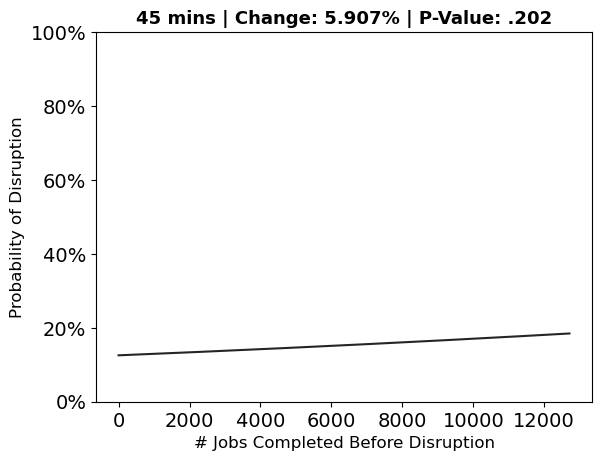

In [140]:
job_45min_log = smf.logit("ErrorCheck ~ JobEndCount",
                         data = job_errors_45min).fit()

fit_df = pd.DataFrame({
        'JobEndCount': np.linspace(start = job_errors_45min['JobEndCount'].min(),
                                stop = job_errors_45min['JobEndCount'].max(),
                                num = 200)
        })

fit_df['fit'] = job_45min_log.predict(fit_df)

fontSize = 14
plt.figure(figsize=(4, 17))

ax = fit_df.plot(
    x="JobEndCount", 
    y="fit", 
    kind="line", 
    color='Black', 
    alpha = .855,
    legend=False
)

def to_percent(y, _):
    return f"{y * 100:.0f}%"  

ax.yaxis.set_major_formatter(FuncFormatter(to_percent))


plt.xticks(rotation=0, fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.ylim(0, 1)
plt.xlabel('# Jobs Completed Before Disruption', fontsize = 12)
plt.ylabel('Probability of Disruption', fontsize = 12)
plt.title(f'45 mins | Change: {(fit_df["fit"].max() - fit_df["fit"].min()) * 100:.3f}% | P-Value: .202', fontsize = 13, fontweight = 'bold');
#plt.text(0.5, 1.03, f'Prediction P-Value: {0.04 }', fontsize=11, ha='center', transform=ax.transAxes)
plt.savefig('../assets/log45min.png', dpi = 150);

job_45min_log.summary()

Optimization terminated successfully.
         Current function value: 0.424350
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             ErrorCheck   No. Observations:                 8925
Model:                          Logit   Df Residuals:                     8923
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:               0.0003592
Time:                        11:25:39   Log-Likelihood:                -3787.3
converged:                       True   LL-Null:                       -3788.7
Covariance Type:            nonrobust   LLR p-value:                   0.09899
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.7596      0.036    -49.256      0.000      -1.830      -1.690
JobEndCount   3.91e-05   2.32e-05      1.689      0.091   -6.28e-06    8.45e-05
===============================================================================
"""

<Figure size 400x1700 with 0 Axes>

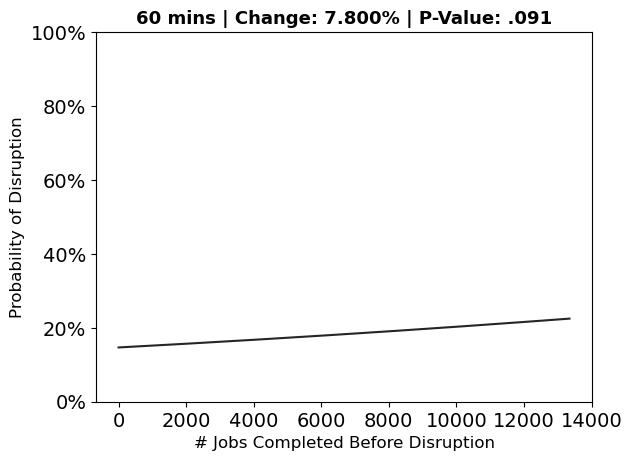

In [141]:
job_60min_log = smf.logit("ErrorCheck ~ JobEndCount",
                         data = job_errors_60min).fit()

fit_df = pd.DataFrame({
        'JobEndCount': np.linspace(start = job_errors_60min['JobEndCount'].min(),
                                stop = job_errors_60min['JobEndCount'].max(),
                                num = 200)
        })

fit_df['fit'] = job_60min_log.predict(fit_df)

fontSize = 14
plt.figure(figsize=(4, 17))

ax = fit_df.plot(
    x="JobEndCount", 
    y="fit", 
    kind="line", 
    color='Black', 
    alpha = .855,
    legend=False
)

def to_percent(y, _):
    return f"{y * 100:.0f}%"  

ax.yaxis.set_major_formatter(FuncFormatter(to_percent))


plt.xticks(rotation=0, fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.ylim(0, 1)
plt.xlabel('# Jobs Completed Before Disruption', fontsize = 12)
plt.ylabel('Probability of Disruption', fontsize = 12)
plt.title(f'60 mins | Change: {(fit_df["fit"].max() - fit_df["fit"].min()) * 100:.3f}% | P-Value: .091', fontsize = 13, fontweight = 'bold');
#plt.text(0.5, 1.03, f'Prediction P-Value: {0.04 }', fontsize=11, ha='center', transform=ax.transAxes)
plt.savefig('../assets/log60min.png', dpi = 150);

job_60min_log.summary()

In [53]:
job_errors_15min = job_errors_15min.replace(np.NaN, 0)
job_errors_30min = job_errors_30min.replace(np.NaN, 0)
job_errors_45min = job_errors_45min.replace(np.NaN, 0)
job_errors_60min = job_errors_60min.replace(np.NaN, 0)


In [55]:
job_errors_15min

,end_group,JobEndCount,ErrorCount,ErrorCheck
0,2020-10-01 00:00:00,3,0.0,0
1,2020-10-01 00:15:00,30,0.0,0
2,2020-10-01 00:30:00,133,0.0,0
3,2020-10-01 00:45:00,255,0.0,0
4,2020-10-01 01:00:00,263,0.0,0
...,...,...,...,...
35694,2021-10-07 19:30:00,2,0.0,0
35695,2021-10-07 19:45:00,2,0.0,0
35696,2021-10-07 20:00:00,2,0.0,0
35697,2021-10-07 20:15:00,2,0.0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ErrorCount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.507
Date:                Sat, 07 Dec 2024   Prob (F-statistic):            0.00615
Time:                        11:26:03   Log-Likelihood:                -23642.
No. Observations:               35699   AIC:                         4.729e+04
Df Residuals:                   35697   BIC:                         4.731e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0964      0.003     33.273      0.000       0.091       0.102
JobEndCount  -1.98e-05   7.23e-06     -2.740      0.006    -3.4e-05   -5.64e-06
==============================================================================
Omnibus:                    51507.115   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20669531.254
Skew:                           8.684   Prob(JB):                         0.00
Kurtosis:                     119.594   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

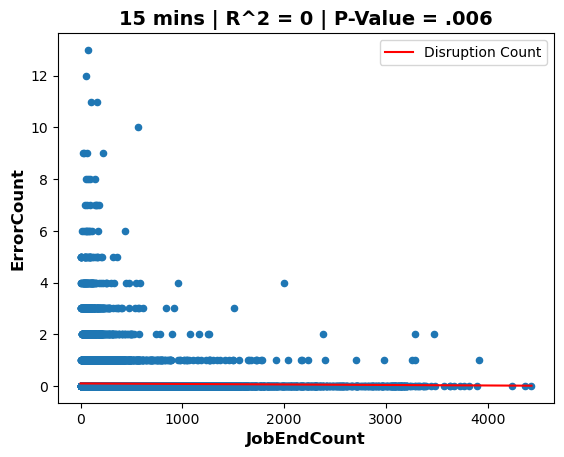

In [142]:
linreg_15 = smf.ols("ErrorCount ~ JobEndCount", data=job_errors_15min).fit()
linreg_15.summary()
pred_df = pd.DataFrame(
    {
        'JobEndCount': np.linspace(start=job_errors_15min['JobEndCount'].min(), stop=job_errors_15min['JobEndCount'].max())
    }
)

pred_df['Disruption Count'] = linreg_15.predict(pred_df)
pred_df
fig, ax = plt.subplots()
ax.set_title("15 mins | R^2 = 0 | P-Value = .006", fontsize=14, fontweight="bold")
ax.set_xlabel("Jobs Completed Before Disruption", fontsize=12, fontweight="bold")
ax.set_ylabel("Disruptions in timeframe", fontsize=12, fontweight="bold")

job_errors_15min.plot(kind="scatter", x="JobEndCount", y="ErrorCount", ax=ax)
pred_df.plot(kind="line", x="JobEndCount", y="Disruption Count", color="red", ax=ax);

plt.savefig('../assets/lin15min.png', dpi = 150);

linreg_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ErrorCount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.820
Date:                Sat, 07 Dec 2024   Prob (F-statistic):             0.0159
Time:                        11:26:28   Log-Likelihood:                -20128.
No. Observations:               17850   AIC:                         4.026e+04
Df Residuals:                   17848   BIC:                         4.028e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1933      0.007     29.056      0.000       0.180       0.206
JobEndCount -2.104e-05   8.72e-06     -2.412      0.016   -3.81e-05   -3.95e-06
==============================================================================
Omnibus:                    23222.239   Durbin-Watson:                   1.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5226269.334
Skew:                           7.280   Prob(JB):                         0.00
Kurtosis:                      85.553   Cond. No.                         907.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

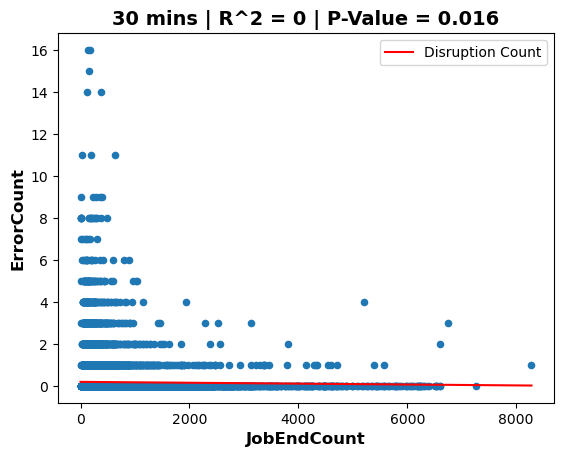

In [143]:
linreg_30 = smf.ols("ErrorCount ~ JobEndCount", data=job_errors_30min).fit()
linreg_30.summary()
pred_df = pd.DataFrame(
    {
        'JobEndCount': np.linspace(start=job_errors_30min['JobEndCount'].min(), stop=job_errors_30min['JobEndCount'].max())
    }
)

pred_df['Disruption Count'] = linreg_30.predict(pred_df)
pred_df
fig, ax = plt.subplots()

ax.set_title("30 mins | R^2 = 0 | P-Value = 0.016", fontsize=14, fontweight="bold")
ax.set_xlabel("Jobs Completed Before Disruption", fontsize=12, fontweight="bold")
ax.set_ylabel("Disruptions in timeframe", fontsize=12, fontweight="bold")

job_errors_30min.plot(kind="scatter", x="JobEndCount", y="ErrorCount", ax=ax)
pred_df.plot(kind="line", x="JobEndCount", y="Disruption Count", color="red", ax=ax);
plt.savefig('../assets/lin30min.png', dpi = 150);

linreg_30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ErrorCount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.532
Date:                Sat, 07 Dec 2024   Prob (F-statistic):             0.0333
Time:                        10:32:40   Log-Likelihood:                -17251.
No. Observations:               11900   AIC:                         3.451e+04
Df Residuals:                   11898   BIC:                         3.452e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2905      0.011     25.497      0.000       0.268       0.313
JobEndCount -2.185e-05   1.03e-05     -2.129      0.033    -4.2e-05   -1.73e-06
==============================================================================
Omnibus:                    15398.190   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3337076.982
Skew:                           7.203   Prob(JB):                         0.00
Kurtosis:                      83.763   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

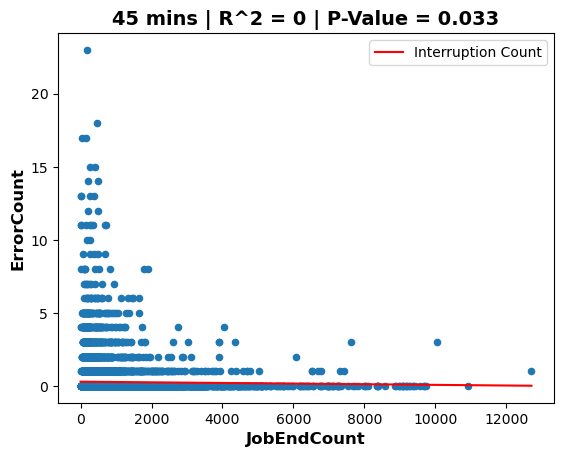

In [124]:
linreg_45 = smf.ols("ErrorCount ~ JobEndCount", data=job_errors_45min).fit()
linreg_45.summary()
pred_df = pd.DataFrame(
    {
        'JobEndCount': np.linspace(start=job_errors_45min['JobEndCount'].min(), stop=job_errors_45min['JobEndCount'].max())
    }
)

pred_df['Disruption Count'] = linreg_45.predict(pred_df)
pred_df
fig, ax = plt.subplots()

ax.set_title("45 mins | R^2 = 0 | P-Value = 0.033", fontsize=14, fontweight="bold")
ax.set_xlabel("Jobs Completed Before Disruption", fontsize=12, fontweight="bold")
ax.set_ylabel("Disruption in timeframe", fontsize=12, fontweight="bold")

job_errors_45min.plot(kind="scatter", x="JobEndCount", y="ErrorCount", ax=ax)
pred_df.plot(kind="line", x="JobEndCount", y="Disruption Count", color="red", ax=ax);

plt.savefig('../assets/lin45min.png', dpi = 150);

linreg_45.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ErrorCount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.540
Date:                Sat, 07 Dec 2024   Prob (F-statistic):             0.0331
Time:                        11:27:36   Log-Likelihood:                -14978.
No. Observations:                8925   AIC:                         2.996e+04
Df Residuals:                    8923   BIC:                         2.997e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3896      0.017     23.310      0.000       0.357       0.422
JobEndCount -2.463e-05   1.16e-05     -2.131      0.033   -4.73e-05   -1.97e-06
==============================================================================
Omnibus:                    10952.154   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1674064.223
Skew:                           6.642   Prob(JB):                         0.00
Kurtosis:                      68.767   Cond. No.                     1.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

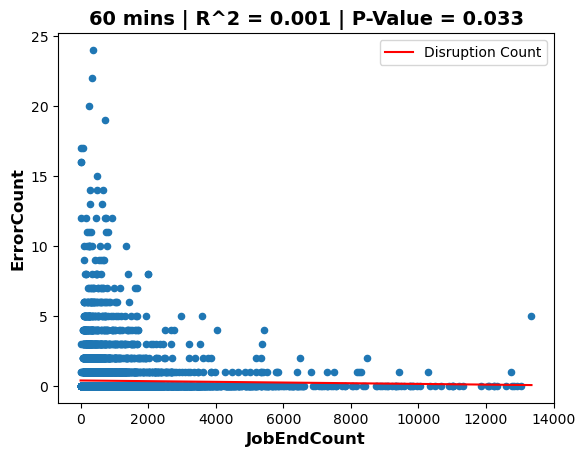

In [144]:
linreg_60 = smf.ols("ErrorCount ~ JobEndCount", data=job_errors_60min).fit()
linreg_60.summary()
pred_df = pd.DataFrame(
    {
        'JobEndCount': np.linspace(start=job_errors_60min['JobEndCount'].min(), stop=job_errors_60min['JobEndCount'].max())
    }
)

pred_df['Disruption Count'] = linreg_60.predict(pred_df)
pred_df
fig, ax = plt.subplots()

ax.set_title("60 mins | R^2 = 0.001 | P-Value = 0.033", fontsize=14, fontweight="bold")
ax.set_xlabel("Jobs Completed Before Disruption", fontsize=12, fontweight="bold")
ax.set_ylabel("Disruptions in timeframe", fontsize=12, fontweight="bold")

job_errors_60min.plot(kind="scatter", x="JobEndCount", y="ErrorCount", ax=ax)
pred_df.plot(kind="line", x="JobEndCount", y="Disruption Count", color="red", ax=ax);

plt.savefig('../assets/lin60min.png', dpi = 150);

linreg_60.summary()

In [132]:
overall_15min_mean = job_errors_15min['JobEndCount'].mean()
overall_30min_mean = job_errors_30min['JobEndCount'].mean()
overall_45min_mean = job_errors_45min['JobEndCount'].mean()
overall_60min_mean = job_errors_60min['JobEndCount'].mean()
disruption_15min_mean = df15min[1].mean()
disruption_30min_mean = df30min[1].mean()
disruption_45min_mean = df45min[1].mean()
disruption_60min_mean = df1hour[1].mean()

In [145]:
disruption_60min_mean

714.8549757281553

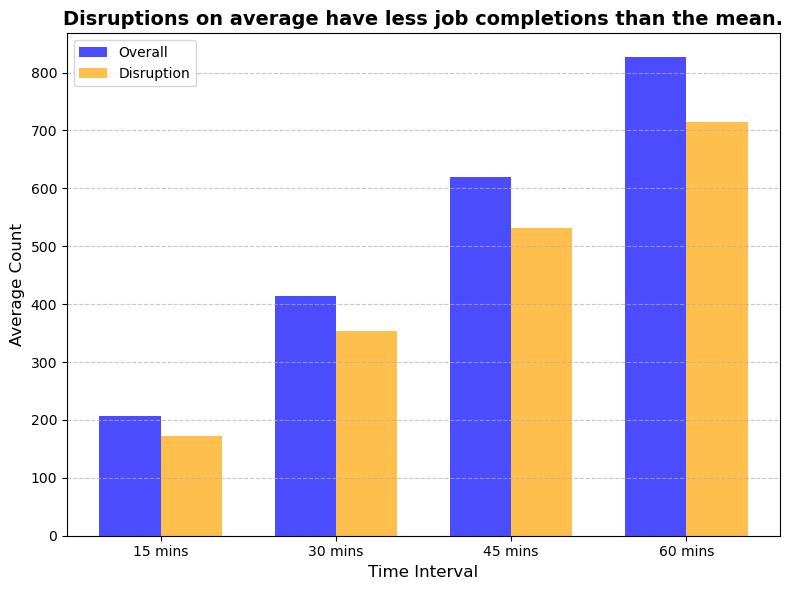

In [136]:
data = {
    "Interval": ["15 mins", "30 mins", "45 mins", "60 mins"],
    "Overall": [
        job_errors_15min['JobEndCount'].mean(),
        job_errors_30min['JobEndCount'].mean(),
        job_errors_45min['JobEndCount'].mean(),
        job_errors_60min['JobEndCount'].mean()
    ],
    "Disruption": [
        df15min[1].mean(),
        df30min[1].mean(),
        df45min[1].mean(),
        df1hour[1].mean()
    ]
}


df = pd.DataFrame(data)
x = np.arange(len(df))  
bar_width = 0.35  
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - bar_width / 2, df["Overall"], bar_width, label="Overall", color="blue", alpha=0.7)
ax.bar(x + bar_width / 2, df["Disruption"], bar_width, label="Disruption", color="orange", alpha=0.7)


ax.set_xlabel("Time Interval", fontsize=12)
ax.set_ylabel("Average Count", fontsize=12)
ax.set_title("Disruptions on average have less job completions than the mean.", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(df["Interval"], fontsize=10)
ax.legend(fontsize=10)


ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.savefig('../assets/averagecomparison.png', dpi = 150);

